This project implements and trains an Artificial Neural Network (ANN) from scratch to perform image classification on the MNIST dataset. MNIST is a standard benchmark in computer vision, consisting of grayscale images of handwritten digits (0 to 9), each with a shape of 28×28 pixels.

The goal of the project is to develop a neural model that can accurately recognize the digit present in each image, without relying on high-level machine learning frameworks. All components of the network, including forward propagation, loss calculation, and backpropagation, are constructed manually to provide a deeper understanding of how ANNs function internally.

Note: All required libraries have been pre-imported. No additional imports are necessary.

The initial code section handles data collection and preprocessing. The core implementation and training logic follow.

In [ ]:
# Importing Libraries

import numpy as np
import tqdm
import random
import sys
from keras.datasets import mnist
from  sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense
from keras.models import StandardScaler

We will use the [mnist](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data) documentation, to load the MNIST dataset. The variable names are as given below:

1. x_train: Train Input
2. y_train: Train Labels
3. x_test: Test Input
4. y_test: Test Labels

Then, we split the training data into training and validation data to evaluate the model during each training epoch.  Before split, the training data has 60000 data points. After the split, ensure training and validation data have 50000 and 10000 points respeectively. The variable names for the validation data are as given below:
1. x_valid: Valid Input
2. y_valid: Valid Labels

After execution, your train, validation, and test data will have 50000, 10000, and 10000 data points each.

In [ ]:
# Data Preprocessing

# Load the MNIST Dataset with variable names as given above
(x_train, y_train), (x_test, y_test) = mnist.load_data()

orig_train = x_train

# Normalize the pixel values between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Flatten the images into 1D arrays
x_train = x_train.reshape((len(x_train), 784))
x_test = x_test.reshape((len(x_test), 784))

# Convert the class labels into one-hot encoded vectors
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

# Split the train data into training and validation data
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.16666, random_state=42)


# Print the shapes of the data arrays
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_valid shape:', x_valid.shape)
print('y_valid shape:', y_valid.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (50000, 784)
y_train shape: (50000, 10)
x_valid shape: (10000, 784)
y_valid shape: (10000, 10)
x_test shape: (10000, 784)
y_test shape: (10000, 10)


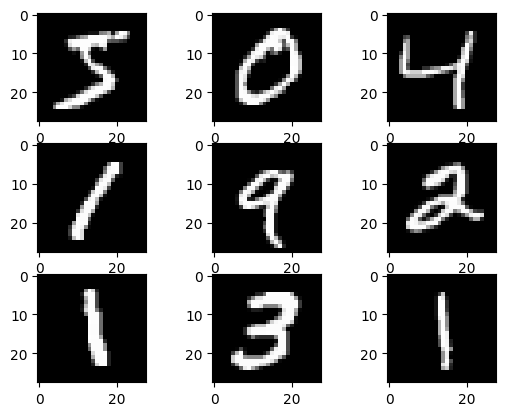

In [ ]:

# Plot the first 9 images in the dataset
for i in range(9):
 plt.subplot(330 + 1 + i)
 plt.imshow(orig_train[i], cmap=plt.get_cmap('gray'))
plt.show()

## Implementing the Multilayer Perceptron (MLP)

This section involves constructing a fully connected feedforward neural network, or **Multilayer Perceptron (MLP)**, with three layers. The network is designed to process inputs from the MNIST dataset and produce digit classification predictions.

### Architecture Overview

- **Input**: The input tensor has shape `[B, 784]`, where `B` is the batch size, and each example is a flattened 28×28 grayscale image.
- **First Hidden Layer (`a1`)**: Fully connected, with 256 neurons and ReLU activation.
- **Second Hidden Layer (`a2`)**: Fully connected, with 128 neurons and ReLU activation.
- **Output Layer (`a3`)**: Fully connected, with 10 neurons and sigmoid activation, yielding a vector of values between 0 and 1 for each class.

The class `MLP` maintains the following weight matrices:

- `self.W1`: Weights between input and first hidden layer  
- `self.W2`: Weights between the first and second hidden layers  
- `self.W3`: Weights between the second hidden layer and output layer  

### Activation Functions

- **ReLU**: Used in the first and second hidden layers, defined as:

  $$
  \text{ReLU}(z) = \max(0, z)
  $$

- **Sigmoid**: Used in the output layer, defined as:

  $$
  \text{sigmoid}(z) = \frac{1}{1 + \exp(-z)}
  $$


### Loss Function

The model is trained using **squared loss**. Each output vector `a3` is compared to a one-hot encoded target vector `y`. For a single training example, the loss is computed as: 
$$
\text{Loss} = 0.5 \cdot \| a_3 - y \|^2
$$


This encourages the output corresponding to the correct class to approach 1, while all others approach 0.

### Required Components

The following functions are defined and implemented as part of the `MLP`:

- `ReLU`: Applies the rectified linear unit activation  
- `dReLU`: Computes the derivative of ReLU  
- `sigmoid`: Applies the sigmoid activation function  
- `dsigmoid`: Computes the derivative of the sigmoid function  
- `forward`: Performs forward propagation from input to output  
- `backprop`: Computes gradients for all weights using backpropagation  
- `apply_sgd`: Applies stochastic gradient descent updates to the weights  

Although the derivatives `dReLU` and `dsigmoid` are not strictly required to pass basic tests, their inclusion significantly simplifies the gradient calculations during backpropagation.





In [ ]:
class MLP:
    def __init__(self, batch = 64, lr = 1e-2, epochs = 50):

        '''

        Initialization Function

        '''
        self.batch = batch
        self.epochs = epochs
        self.lr = lr

        self.loss = []
        self.acc = []

        # Add here any other variable intitalization you want (if any - you do not need to modify this function

        self.init_weights()

    def init_weights(self):

        '''

        This function initializes the weights for the neural network

        '''

        # We initialize the weights with appropriate dimensions (based on the input and output dimension) using np.random() function
        # There should be 256 neurons in the first hidden layer, and 128 neurons in the second hidden layer
        # The scalings are magical constants that produce "He initialization". You can google "Xavier He initialization" to learn more about different initialization schemes.
        # These scalings make SGD work better, and also help avoid numerical overflow issues in the final sigmoid activation.

        self.W1 = np.random.randn(784, 256) / (0.5 * np.sqrt(784))
        self.W2 = np.random.randn(256, 128) / (0.5 * np.sqrt(256))
        self.W3 = np.random.randn(128, 10)  / np.sqrt(128)

    def ReLU(self, z):

        '''

        Computes the Rectified Linear Unit (ReLU) activation on the given input and returns the output.
        The ReLU activation function sets all negative values in the input to 0, and leaves all non-negative values unchanged.

        arguments:
        z: The input to the ReLU activation function.

        returns:
        The output of the ReLU activation function, which is the element-wise maximum of 0 and the input. Should have the same shape as z
        ReLU(z) = max(0, z)

        '''
        # Compute ReLU activation on the given input and return the output

        return np.maximum(0, z)

    def dReLU(self, z):

        '''

        Computes the derivative of the Rectified Linear Unit (ReLU) activation on the given input and returns the output.
        The derivative of the ReLU activation function is 1 for all non-negative input values, and 0 for all negative input values.

        arguments:
        z: The input to the dReLU function.

        returns:
        The output of the dReLU function, which is the element-wise derivative of the ReLU activation function. Should have the same shape as z
        ReLU(z) = max(0, z)

        '''
        # Compute the derivative of ReLU activation on the given input and return the output
        # Ignore any points of non-differentiability.

        return (z > 0).astype(float)

    def sigmoid(self, z):

        '''

        Computes the Sigmoid activation on the given input and returns the output.

        arguments:
        z: The input to the Sigmoid function

        returns:
        The output of the Sigmoid function, should have the same shape as x
        sigmoid(z) = 1/(1 + e^-z)

        '''

        # Compute Sigmoid activation on the given input and return the output

        return 1 / (1 + np.exp(-z))

    def dsigmoid(self, z):

        '''

        Computes the derivative of the Sigmoid activation on the given input and returns the output.

        arguments:
        z: The input to the dsigmoid function.

        returns:
        The output of the dsigmoid function, which is the element-wise derivative of the sigmoid activation function.
        sigmoid(z) = 1/(1 + e^z)

        '''

        # Compute the derivative of Sigmoid activation on the given input and return the output


        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def forward(self, X):

        '''
        Computes the forward pass on the network.

        Performs the mathematical operations on the weights andinputs, and makes a prediction using a neural network with three hidden layers.
        The forward pass of the neural network is implemented by performing the following operations:


        arguments:
        X: The input data on which the model has to make predictions. Should have shape [B, 784] for some B

        returns:
        a3: the output layer. Should have shape [B, 10]

        This function should use the weight matrices W1, W2, W3 to compute the output of the network.
        The first two layers (the hidden layers) should use the ReLU activation function.
        The last layer (the output layer) should use the sigmoid activation function.

        So, if v1 = X W1, then the first hidden layer is a1 = ReLU(v1)

        Similarly, if v3 = a3 W3, then the output layer is a3 = sigmoid(v3)

        You must store a3 in self.a3 for access in later functions.

        You will also probably find it helpful to store some intermediate values you compute during the forward pass (like hidden layer activations)
        as attributes of self. For example, you will likely want to store self.a1.
        These stored values will not be checked in our checking code, but you will probably need them when you implement the backward pass.

        You MUST NOT store intermediate values in global scope (this would be somewhat difficult to do, but do not try to do it).

        '''

        # Perform the mathematical operations on the weights, inputs, and bias and make a prediction.
        # The prediction should be stored in self.a3, and also returned from this function.


        self.X = X
        self.v1 = np.dot(self.X, self.W1)
        self.a1 = self.ReLU(self.v1)
        self.v2 = np.dot(self.a1, self.W2)
        self.a2 = self.ReLU(self.v2)
        self.v3 = np.dot(self.a2, self.W3)
        self.a3 = self.sigmoid(self.v3)

        return self.a3

    def squared_loss(self, y, y_preds):

        '''
        Computes the squared loss of the neural network's prediction.

        arguments:
        y: The true label(s) for the input(s) to the neural network.
        y_preds: The predicted label(s) for the input(s) to the neural network

        returns:
        error: The squared loss between the predicted output of the neural network and the true label(s).

        '''
        loss = 0.5 * np.sum((y - y_preds)**2)/np.shape(y)[0]

        return loss

    def backprop(self, x, y):

        '''

        Computes the gradient of all weights and biases of the neural network based on the errors made during training.
        This function performs backpropagation on the neural network to update the weights and biases.
        It first computes the error of the model on all training batches.
        Then, it finds the derivative of the loss with respect to each weight vector and bias.

        arguments:
        x: The input data on which the model made predictions during the forward pass. Shape = [B, 784] for batch size B
        y: The true label(s) for the input(s) to the neural network.  Shape = [B, 10] for batch size B

        This function need not return anything.
        However, it must set the following variables:

        self.dLdW3: shape [128, 10]
        self.dLdW2: shape [256, 128]
        self.dLdW1: shape [784, 256]

        Each of these should hold the gradient of the loss computed by squared_loss(forward(x), y) with respect to Wi.
        '''

        m = x.shape[0]

        dA3 = self.a3 - y
        dV3 = self.dsigmoid(self.v3) * dA3
        self.dLdW3 = np.dot(self.a2.T, dV3) / m

        dA2 = np.dot(dV3, self.W3.T)
        dV2 = self.dReLU(self.v2) * dA2
        self.dLdW2 = np.dot(self.a1.T, dV2) / m

        dA1 = np.dot(dV2, self.W2.T)
        dV1 = self.dReLU(self.v1) * dA1
        self.dLdW1 = np.dot(x.T, dV1) / m

        assert self.dLdW3.shape == self.W3.shape
        assert self.dLdW2.shape == self.W2.shape
        assert self.dLdW1.shape == self.W1.shape

    def apply_sgd(self):

        '''

        Updates the weights and biases of the neural network based on the gradient found in the backpropogation step.
        The updates should be performed by subtracting from the weight the learning rate times the corresponding derivative of the weight/bias.

        Using the learning rate self.lr, this function should implement

        W = W - lr * gradient of loss with respect to W

        for all parameters W.

        After this function is finished,
        self.W1, self.W2 and self.W3 should all contain the updated values for W1, W2, W3.
        '''
        # Update the weights using the derivatives calculated above
        # DO NOT call `backprop` in this function: this function should ASSUME that `backprop` has already been called!

        self.W3 = self.W3 - self.lr * self.dLdW3
        self.W2 = self.W2 - self.lr * self.dLdW2
        self.W1 = self.W1 - self.lr * self.dLdW1


    def shuffle(self, x, y):

        '''

        This function shuffles the input data and corresponding labels in order to ensure randomness in the order of training examples.

        arguments:

        x: The input data on which the model has to make predictions (shape [B, 784] for some integer B)
        y: The true label(s) for the input(s) to the neural network. (shape [B, 10] for some integer B)

        returns:
        shuffled input data and corresponding labels

        '''

        idx = [i for i in range(x.shape[0])]
        np.random.shuffle(idx)
        x = x[idx]
        y = y[idx]
        return x, y

    def train(self, xtrain, ytrain, xvalid, yvalid):

        '''

        This function performs the training of the neural network using all the functions defined above.

        arguments:
        xtrain: The training data (shape [B, 784])
        ytrain: The labels for the training data (shape [B, 10])
        xvalid: The validation data (shape [C, 784])
        yvalid: The labels for the validation data (shape [C, 10])

        '''
        for epoch in range(self.epochs):
            l = 0
            acc = 0
            xtrain, ytrain = self.shuffle(xtrain, ytrain)

            for batch in range(xtrain.shape[0]//self.batch-1):
                start = batch*self.batch
                end = (batch + 1)*self.batch
                x = np.array(xtrain[start:end])
                y = np.array(ytrain[start:end])
                self.forward(x)
                l += self.squared_loss(y, self.a3)

                acc += np.count_nonzero(np.argmax(self.a3, axis = 1) == np.argmax(y, axis = 1)) / self.batch
                self.backprop(x, y)
                self.apply_sgd()

            valid_acc = self.test(xvalid, yvalid)
            print("Epoch " + str(epoch + 1) + ":")
            print("Training Accuracy: %.2f%%" % (acc*100/(xtrain.shape[0]//self.batch)))
            print("Validation Accuracy: %.2f%% \n" % (valid_acc*100))
            self.loss.append(l/(xtrain.shape[0]//self.batch))
            self.acc.append(acc*100/(xtrain.shape[0]//self.batch))

    def plot(self):

        '''

        This function will be used to plot the overall training accuracy and loss graphs for the trained Neural Network

        '''

        fig, axs = plt.subplots(2)
        fig.tight_layout(pad = 3.0)
        plt.title("Model Loss and Accuracy")
        axs[0].set_title("Loss Plot")
        axs[0].set_xlabel("Epochs")
        axs[0].set_ylabel("Loss")
        axs[0].plot(self.loss)
        axs[1].set_title("Accuracy Plot")
        axs[1].set_xlabel("Epochs")
        axs[1].set_ylabel("Accuracy")
        axs[1].plot(self.acc)

    def test(self, xtest, ytest):

        '''

        This function takes in the test data and respective labels and evaluates the accuracy of the neural network on this data.

        arguments:
        xtest: The test data
        ytest: The labels for the test data

        returns:
        acc: accuracy of the model on the given test data

        '''

        self.forward(xtest)
        acc = np.count_nonzero(np.argmax(self.a3, axis = 1) == np.argmax(ytest, axis = 1)) / xtest.shape[0]
        return acc

    def predict(self, x):

        '''

        Functions exactly like the test() function, except it returns the predictions instead of accuracy

        arguments:
        x: The data

        returns:
        predictions: Predictions of the model on the input data

        '''

        predictions = []
        for i in x:
          image = i.reshape(1, -1)
          self.forward(image)
          predictions.append(np.argmax(self.a3, axis = 1))
        return np.array(predictions)

### Gradient Check via Numerical Differencing

This section performs a numerical gradient check to validate the correctness of the `forward` and `backprop` implementations.

The test compares the analytical gradients computed by backpropagation to numerical estimates obtained using the following identity:

Given a scalar-valued function $F(\theta) \in \mathbb{R}$ and a sufficiently small perturbation vector $v$, the following approximation should hold:

$$
\frac{v^\top \nabla F(\theta)}{\|v\|} \approx \frac{F(\theta + v) - F(\theta)}{\|v\|}
$$

The test function samples five different random small vectors $v$, computes $\nabla F(\theta)$ using `backprop`, and checks the approximation above for each case.

> **Note:** A small probability exists that a correct implementation may fail due to randomness. However, this is uncommon. Re-running the test usually resolves this.


In [ ]:
def backprop_test():
  count = 0
  for i in range(5):
    print(f"Running backprop test replicate {i+1} of 5...")
    test = MLP(64, 5e-3, 1)
    check_no_globals = MLP(64, 5e-3, 1)
    x, y = test.shuffle(x_train, y_train)
    yhat = test.forward(x)
    computed_loss = test.squared_loss(y, yhat)

    test.backprop(x, y)
    first_dW1 = test.dLdW1.copy()
    check_no_globals = MLP(64, 5e-3, 1)
    test.backprop(x, y)
    if np.linalg.norm(first_dW1 - test.dLdW1) > 1e-7:
      print(f"The backprop output changed after running a forward pass on an independent model... did you store some intermediate values in global scope?")
      count += 1

    param_count = (784 * 256) + (256 * 128) + (128 * 10)# + 256 + 128 + 10
    v_scale = 1e-6 /np.sqrt(param_count)

    v_W1 = np.random.normal(0, v_scale, (784 * 256)).reshape(test.W1.shape)
    v_W2 = np.random.normal(0, v_scale, (256 * 128)).reshape(test.W2.shape)
    v_W3 = np.random.normal(0, v_scale, (128 * 10)).reshape(test.W3.shape)

    dot_prod = 0
    dot_prod += np.sum(test.dLdW1 * v_W1)
    dot_prod += np.sum(test.dLdW2 * v_W2)
    dot_prod += np.sum(test.dLdW3 * v_W3)

    Wv1 = test.W1 + v_W1.reshape(784, 256)
    Wv2 = test.W2 + v_W2.reshape(256, 128)
    Wv3 = test.W3 + v_W3.reshape(128, 10)

    l1 = test.squared_loss(y, test.sigmoid(test.ReLU(test.ReLU(x.dot(test.W1)).dot(test.W2)).dot(test.W3)))
    l2 = test.squared_loss(y, test.sigmoid(test.ReLU(test.ReLU(x.dot(    Wv1)).dot(    Wv2)).dot(    Wv3)))

    if np.abs(computed_loss - l1)/(np.abs(computed_loss) + np.abs(l1)) > 1e-5:
      print("there is an error in forward: expected value: {l1}, implemented value: {computed_loss}")
      count += 1

    norm = 0
    norm += np.linalg.norm(v_W1)**2
    norm += np.linalg.norm(v_W2)**2
    norm += np.linalg.norm(v_W3)**2
    norm = np.sqrt(norm)
    t1 = dot_prod/norm
    t2 = (l2 - l1)/norm
    error = abs(t1 - t2)/(abs(t1) +  abs(t2))
    if error > 1e-4:
      print(f"backprop check failure with (computed grad - numerical grad)/ (computed_grad + numerical grad): {error}, computed grad: {t1}, numerical grad: {t2}")
      count+=1
  if count >= 1:
    print("Something is wrong...")
  else:
    print("Great Job, backprop check passed!")

backprop_test()

Running backprop test replicate 1 of 5...
Running backprop test replicate 2 of 5...
Running backprop test replicate 3 of 5...
Running backprop test replicate 4 of 5...
Running backprop test replicate 5 of 5...
Great Job, backprop check passed!


## Train the MLP

1. **Initialize the model**: Create an instance of the `MLP` class, passing in the training and validation datasets along with the following hyperparameters:
   - Batch size: 64  
   - Learning rate: 1.0  
   - Number of epochs: 20

2. **Train the model**: Use the `train()` method to fit the model to the training data.

3. **Visualize progress**: Plot training accuracy and training loss using the `plot()` method to assess convergence and model performance over time.

4. **Evaluate test accuracy**: Use the `test()` method to compute and print the model’s accuracy on the test set.

### Performance Notes

- The reference implementation completes all 20 epochs in approximately **1 minute and 30 seconds**.
- If training exceeds **15 seconds per epoch**, this may indicate inefficiencies in the implementation.
- Full credit requires the model to achieve **at least 97% test accuracy**.  
- For reference:
  - A linear classifier typically reaches ~93% on this task  
  - The benchmark MLP implementation achieves **over 98%** accuracy

Epoch 1:
Training Accuracy: 90.02%
Validation Accuracy: 95.28% 

Epoch 2:
Training Accuracy: 96.12%
Validation Accuracy: 96.54% 

Epoch 3:
Training Accuracy: 97.21%
Validation Accuracy: 97.14% 

Epoch 4:
Training Accuracy: 97.88%
Validation Accuracy: 97.05% 

Epoch 5:
Training Accuracy: 98.19%
Validation Accuracy: 97.54% 

Epoch 6:
Training Accuracy: 98.58%
Validation Accuracy: 97.71% 

Epoch 7:
Training Accuracy: 98.83%
Validation Accuracy: 97.68% 

Epoch 8:
Training Accuracy: 98.96%
Validation Accuracy: 98.08% 

Epoch 9:
Training Accuracy: 99.11%
Validation Accuracy: 98.02% 

Epoch 10:
Training Accuracy: 99.26%
Validation Accuracy: 98.09% 

Epoch 11:
Training Accuracy: 99.35%
Validation Accuracy: 98.02% 

Epoch 12:
Training Accuracy: 99.42%
Validation Accuracy: 98.04% 

Epoch 13:
Training Accuracy: 99.48%
Validation Accuracy: 98.23% 

Epoch 14:
Training Accuracy: 99.51%
Validation Accuracy: 98.22% 

Epoch 15:
Training Accuracy: 99.53%
Validation Accuracy: 98.31% 

Epoch 16:
Training 

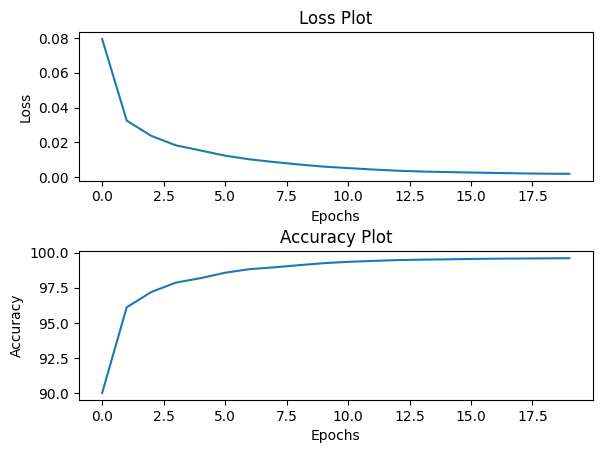

In [ ]:
nn = MLP(batch=64, lr=1.0, epochs=20)

nn.train(x_train, y_train, x_valid, y_valid)

nn.plot()

test_accuracy = nn.test(x_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

<ipython-input-28-95941558950b>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[row, col].set_title("Model Prediction: %d, True Label: %d" % (pred, np.argmax(y_test[x])))


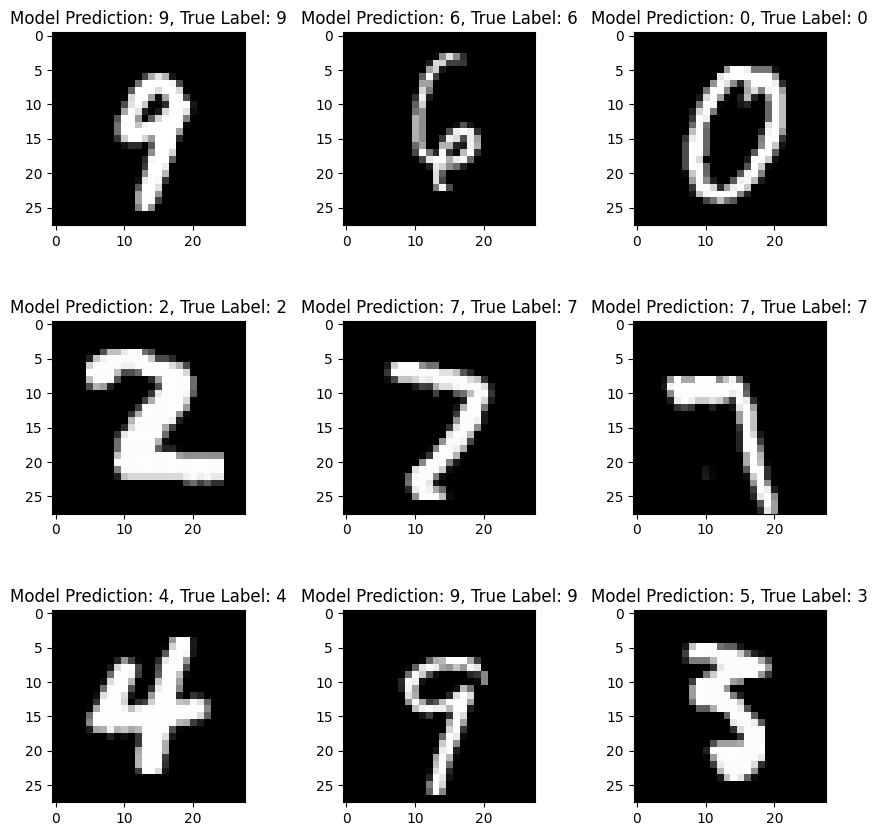

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)


for i in range(9):
    row = i // 3
    col = i % 3
    x = random.randint(0, len(y_test))
    plot_input = x_test[x].reshape(28, 28)
    pred = nn.predict(x_test[x].reshape(1, -1))
    axs[row, col].imshow(plot_input, cmap=plt.get_cmap('gray'))
    axs[row, col].set_title("Model Prediction: %d, True Label: %d" % (pred, np.argmax(y_test[x])))

plt.show()

The final step is to visualize the **confusion matrix** based on the model’s predictions on the test dataset.

The confusion matrix provides insights into the types of errors the model is making. For example, it may reveal systematic misclassifications, such as predicting the digit 4 when the true label is 5.

By analyzing this matrix, one can better understand the strengths and weaknesses of the model and identify patterns in its misclassification behavior.

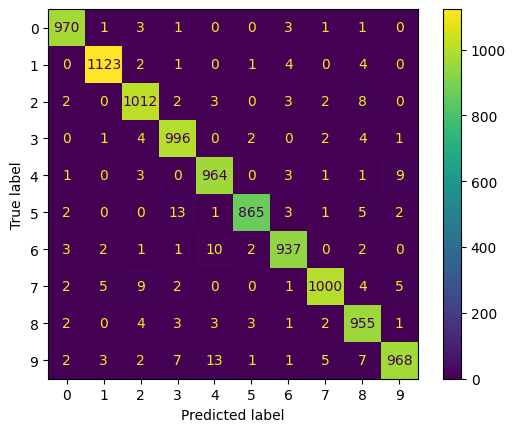

In [ ]:

preds = nn.predict(x_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), preds)
cmdisplay = ConfusionMatrixDisplay(cm)
cmdisplay.plot()
plt.show()
